## Exp 01. Multi-Property Control

This file provides source codes for multi-property control experiment and removal fragment statistics analysis.

First, 100 test molecules are selected by the following rules:
(1) a single neutral molecule, (2) no more than three rings, (3) inclusion of at least one BRICS bond, and (4) molecular weight(MW) falling in the range of 250 to 500.

Then these molecules are queried to DeepBioisostere to yield 100 modified structures for each input molecule and property control condition.

Lastly, for three test molecules, removal fragments are analyzed and their statistics is visualized.

### Basic package loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import json
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Dict, List
from collections import defaultdict
import random
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

from conditioning import Conditioner
from generate import Generator
from model import DeepBioisostere

pd.options.mode.chained_assignment = None

In [3]:
SMILES = str
TO_UPPERCASE = {"logp": "logP", "mw": "Mw", "qed": "QED", "sa": "SA"}
DELTA_PROPS = {
    "Mw": r"$\Delta Mw$",
    "logP": r"$\Delta logP$",
    "QED": r"$\Delta QED$",
    "SA": r"$\Delta SA$",
}
DE_DELTA_PROPS = {
    r"$\Delta Mw$": "Mw",
    r"$\Delta logP$": "logP",
    r"$\Delta QED$": "QED",
    r"$\Delta SA$": "SA",
}

### Define functions

#### For test molecule set construction

In [4]:
from rdkit import Chem
from rdkit.Chem import BRICS

from property import calc_Mw, calc_logP, calc_QED, calc_SAscore

def filter_smi(smi) -> bool:
    # 1. filter by single neutral molecule
    if "." in smi:
        return False
    mol = Chem.MolFromSmiles(smi)
    if Chem.GetFormalCharge(mol) != 0:
        return False

    # 2. filter by molecular weight
    mw = calc_Mw(mol)
    if mw < 250 or mw > 500:
        return False

    # 3. no more than three rings
    if mol.GetRingInfo().NumRings() > 3:
        return False

    # 4. inclusion of at least one BRICS bond
    if len(list(BRICS.FindBRICSBonds(mol))) == 0:
        return False

    return True

def calculate_props(smi) -> tuple:
    mol = Chem.MolFromSmiles(smi)
    return calc_Mw(mol), calc_logP(mol), calc_QED(mol), calc_SAscore(mol)


In [5]:
import random
import multiprocessing as mp

def test_set_construction(num_workers, processed_file_path, num_molecules, seed):
	# Read processed data
	print("Reading processed data...\t", end="")
	data = pd.read_csv(processed_file_path, sep="\t")
	grouped_data = data.groupby("DATATYPE")
	test_smis = grouped_data.get_group("test")["REF-SMI"]

	# separate data in train/validation/test
	props_data_dict = {
		"SMILES": [],
		"MW": [],
		"LOGP": [],
		"QED": [],
		"SA": [],
	}

	print("\n1. Filtering test molecules with basic rules...")
	with mp.Pool(num_workers) as p:
		test_result = p.map(filter_smi, tqdm(test_smis))
	passed_test_molecules = [smi for smi, passed in zip(test_smis, test_result) if passed]
	random.shuffle(passed_test_molecules)

	print("\n2. Calculating properties of molecules...")
	with mp.Pool(num_workers) as p:
		calculated_props = p.map(calculate_props, tqdm(passed_test_molecules))
	mw, logp, qed, sa = zip(*calculated_props)

	props_data_dict["SMILES"] = passed_test_molecules
	props_data_dict["MW"] = mw
	props_data_dict["LOGP"] = logp
	props_data_dict["QED"] = qed
	props_data_dict["SA"] = sa
	props_df = pd.DataFrame(props_data_dict)

	print(f"\n3. Selecting {num_molecules} molecules for each scenario...")
	# for case 1
	shuffled_props_df = props_df.sample(frac=1, random_state=seed)
	case1_df = shuffled_props_df[(shuffled_props_df["LOGP"]>1) & (shuffled_props_df["LOGP"]<5)].head(num_molecules)
	# remove case1_df smiles from shuffled_props_df
	shuffled_props_df = shuffled_props_df[~shuffled_props_df["SMILES"].isin(case1_df["SMILES"])]
	assert len(case1_df) == num_molecules, f"len(case1_df) = {len(case1_df)} != {num_molecules}"

	# for case 2
	shuffled_props_df = shuffled_props_df.sample(frac=1)
	# case2_df = shuffled_props_df[(shuffled_props_df["QED"]>0.4) & (shuffled_props_df["QED"]<0.6)].head(100)
	case2_df = shuffled_props_df[shuffled_props_df["QED"]<0.4].head(num_molecules)
	# remove case2_df smiles from shuffled_props_df
	shuffled_props_df = shuffled_props_df[~shuffled_props_df["SMILES"].isin(case2_df["SMILES"])]
	assert len(case2_df) == num_molecules, f"len(case2_df) = {len(case2_df)} != {num_molecules}"

	# for case 3
	shuffled_props_df = shuffled_props_df.sample(frac=1)
	case3_df = shuffled_props_df[(shuffled_props_df["QED"]>0.7) & (shuffled_props_df["SA"]>4)].head(num_molecules)
	assert len(case3_df) == num_molecules, f"len(case3_df) = {len(case3_df)} != {num_molecules}"

	# concat
	result_df = pd.concat([case1_df, case2_df, case3_df])
	result_df["CASE"] = ["case1"]*num_molecules + ["case2"]*num_molecules + ["case3"]*num_molecules 
	print("Done!")
	
	return result_df

#### To calculate molecular properties

In [6]:
from property import calc_logP, calc_Mw, calc_QED, calc_SAscore

def calculate_properties(smi: SMILES, props: List[str]) -> Dict[str, float]:
    mol = Chem.MolFromSmiles(smi)
    calculated_values = dict()
    for prop in props:
        if prop == "logp":
            calculated_values["logP"] = calc_logP(mol)
        elif prop == "mw":
            calculated_values["Mw"] = calc_Mw(mol)
        elif prop == "qed":
            calculated_values["QED"] = calc_QED(mol)
        elif prop == "sa":
            calculated_values["SA"] = calc_SAscore(mol)
    return calculated_values

#### For generation

In [7]:
def generate_with_deepbioisostere(
    frag_lib_path,
    model_dir,
    batch_size,
    num_sample_each_mol,
    device,
    input_list,
    num_workers,
    seed=42,
):

    # Calculated properties
    smi_to_conditioning_informs = dict()
    for input_idx, (smi, target_props) in enumerate(input_list):
        if smi in smi_to_conditioning_informs:
            smi_to_conditioning_informs[smi].append(
                " / ".join(
                    [
                        f"{TO_UPPERCASE[key]} {value:.2f}"
                        for key, value in target_props.items()
                    ]
                )
            )
        else:
            smi_to_conditioning_informs[smi] = [
                " / ".join(
                    [
                        f"{TO_UPPERCASE[key]} {value:.2f}"
                        for key, value in target_props.items()
                    ]
                )
            ]

    merged_df = None
    test_cases = ["case1", "case2", "case3"]
    for case in test_cases:
        if case == "case1":
            properties = sorted(["logp", "mw"])
        elif case == "case2":
            properties = sorted(["qed", "mw"])
        elif case == "case3":
            properties = sorted(["qed", "sa"])

        # Gather input molecules that correspond to each case
        corr_input_list = []
        for smi, target_props in input_list:
            if sorted(list(target_props.keys())) == properties:
                corr_input_list.append((smi, target_props))
        if len(corr_input_list) == 0:
            continue

        # Initialize model and dataset
        model_path_for_case = model_dir / f"DeepBioisostere_{'_'.join(properties)}.pt"
        print(f"Used model pathway: {model_path_for_case}")
        model = DeepBioisostere.from_trained_model(
            model_path_for_case, properties=properties
        )
        conditioner = Conditioner(
            phase="generation",
            properties=properties,
        )
        generator = Generator(
            model=model,
            processed_frag_dir=frag_lib_path,
            num_sample_each_mol=num_sample_each_mol,
            device=device,
            num_cores=num_workers,
            batch_size=batch_size,
            new_frag_type="test",
            conditioner=conditioner,
            properties=properties,
        )

        # Generate without specifying leaving fragments
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        print("Generation is going on...")
        result_df = generator.generate(corr_input_list)
        print("Done.\n")

        # Add column for input conditioning information
        unique_input_smiles = list(result_df["INPUT-MOL-SMI"].unique())

        repeated_cond_informs = []
        for input_smi in unique_input_smiles:
            corr_df = result_df[result_df["INPUT-MOL-SMI"] == input_smi]
            input_mol_idx_list = list(corr_df["INPUT-MOL-IDX"].unique())

            for idx, input_mol_idx in enumerate(input_mol_idx_list):
                num_sampled_mols = (
                    result_df["INPUT-MOL-IDX"].to_numpy() == input_mol_idx
                ).sum()
                repeated_cond_informs.extend(
                    [
                        smi_to_conditioning_informs[input_smi][idx]
                        for _ in range(num_sampled_mols)
                    ]
                )

        result_df["PROPERTY_CONDITION"] = repeated_cond_informs

        # Merge to the final dataframe
        if merged_df is None:
            merged_df = result_df
        else:
            result_df["INPUT-MOL-IDX"] += merged_df["INPUT-MOL-IDX"].max() + 1
            merged_df = pd.concat([merged_df, result_df])

    return merged_df

#### For statistical analysis

In [8]:
def metric_mean_variance(
    generation_result_path: Path,
    round=3
) -> Dict[str, Dict[str, Dict[str, list]]]:

    # generation_result_file_name = str(generation_result_path)
    result_df = pd.read_csv(generation_result_path)
    case_to_result = dict()

    # Separate cases
    for case in sorted(list(result_df["CASE"].unique())):
        corr_df = result_df[result_df["CASE"] == case]
        if len(corr_df) == 0:
            continue

        properties = corr_df["PROPERTY_CONDITION"].to_list()[0]
        properties = [p.split(" ")[0].lower() for p in properties.split(" / ")]     # Ex: ["Mw", "logP"]
        input_smis = corr_df["INPUT-MOL-SMI"].unique()

        prop_conditions = corr_df["PROPERTY_CONDITION"].to_list()
        prop_condition1 = prop_conditions[0]
        prop_condition2 = set(prop_conditions) - {prop_condition1}

        if len(prop_condition2) != 0:
            num_conditions = 2
            prop_condition2 = list(prop_condition2)[0]

        cond1_prop_to_delta_dict = {p: [] for p in properties}
        cond2_prop_to_delta_dict = {p: [] for p in properties}

        for smi in input_smis:
            each_df = corr_df[corr_df["INPUT-MOL-SMI"] == smi]
            mol_props = calculate_properties(smi, properties)

            for prop, value in mol_props.items():
                condition1_df = each_df[each_df["PROPERTY_CONDITION"] == prop_condition1] 
                gen_prop_values1 = condition1_df[prop.upper()].to_numpy()
                condition1 = gen_prop_values1 - value
                cond1_prop_to_delta_dict[prop.lower()].extend(condition1.tolist())

                if num_conditions == 2:
                    condition2_df = each_df[each_df["PROPERTY_CONDITION"] == prop_condition2] 
                    gen_prop_values2 = condition2_df[prop.upper()].to_numpy()
                    condition2 = gen_prop_values2 - value
                    cond2_prop_to_delta_dict[prop.lower()].extend(condition2.tolist())

        cond1_prop_to_delta_dict = {
            k: np.array(v) for k, v in cond1_prop_to_delta_dict.items()
        }
        if num_conditions == 2:
            cond2_prop_to_delta_dict = {
                k: np.array(v) for k, v in cond2_prop_to_delta_dict.items()
            }

        cond1_mean_var = {
            k: [np.mean(v).round(round), np.std(v).round(round)] for k, v in cond1_prop_to_delta_dict.items()
        }
        if num_conditions == 2:
            cond2_mean_var = {
                k: [np.mean(v).round(round), np.std(v).round(round)] for k, v in cond2_prop_to_delta_dict.items()
            }

        if num_conditions == 1:
            case_to_result[case] = {"cond1": cond1_mean_var}
        elif num_conditions == 2:
            case_to_result[case] = {"cond1": cond1_mean_var, "cond2": cond2_mean_var}

    return case_to_result


In [9]:
def metric_leaving_frag_difference(leaving_frag_statistics_path: Path, verbose: bool = True) -> float:
    leaving_frag_statistics_path = str(leaving_frag_statistics_path)
    with open(leaving_frag_statistics_path, "r") as f:
        leaving_frag_statistics = json.load(f)

    diffs = []
    num_samples = len(leaving_frag_statistics)
    for smi, statistics in leaving_frag_statistics.items():
        if len(statistics) == 1:
            continue
        diffs.append(calculate_freq_difference(statistics))

    if verbose:
        for idx, (smi, diff) in enumerate(zip(leaving_frag_statistics.keys(), diffs)):
            print(f"{idx}th: {smi} -> leaving fragment count difference: {diff}")

    return sum(diffs) / num_samples

In [10]:
def calculate_freq_difference(statistics: Dict[str, Dict[str, int]], total: int = 100) -> int:
    union_statistics = {}
    for cond, each_result in statistics.items():
        each_dict_sum = 0
        for smi, freq in each_result.items():
            each_dict_sum += freq
            if smi not in union_statistics:
                union_statistics[smi] = freq
            elif union_statistics[smi] < freq:
                union_statistics[smi] = freq
        assert each_dict_sum == total, f"each_dict_sum: {each_dict_sum}, total: {total}"
    return sum(list(union_statistics.values())) - each_dict_sum

### User Settings

In [11]:
# USER SETTINGS
PROJECT_DIR = Path("/home/hwkim/DeepBioisostere")   # Change this to your project directory
num_workers = 8
batch_size = 512
num_sample_each_mol = 10
use_gen_csv_file = False           # If True, previously calculated csv file is used. for initial generation, set it to False
device = "cuda:0"
# frag_lib_path = PROJECT_DIR.joinpath("fragment_library")    # default path!
frag_lib_path = Path("/home/share/DATA/hwkim/DeepBioisostere")               # our own server...

# default paths
csv_save_dir = PROJECT_DIR.joinpath("exps/fig2_multi_conditioning/csv_files")
test_molecule_csv_path = csv_save_dir.joinpath("test_molecules.csv")
generation_result_path = csv_save_dir.joinpath("test_molecules_conditioning_result.csv")

# experiment settings
if use_gen_csv_file and not generation_result_path.exists():
    raise Exception("ERROR! use_gen_csv_file option was set True but the generated csv file is not found.")
if use_gen_csv_file and generation_result_path.exists():
    print("Previously generated csv file is used.")
    new_experiment = False
else:
    print("New csv file for the experiment is to be generated.")
    new_experiment = True

# model path
model_dir = Path(f"{PROJECT_DIR}/model_save/")
print(f"Trained model files directory: {model_dir}")

New csv file for the experiment is to be generated.
Trained model files directory: /home/hwkim/DeepBioisostere/model_save


### Test set construction

In [12]:
if not new_experiment:    # the final result file was already generated and is used.
    print("Prev generation result file is used.")
    pass
else:
    if test_molecule_csv_path.exists():  # previously generated test molecules are used.
        print("New experiment is to be carried out - Previously selected test molecules are used.")
        test_molecule_csv_df = pd.read_csv(test_molecule_csv_path)

    else:       # test molecules are to be generated.
        print("New experiment is to be carried out - New test molecules are to be selected.")
        processed_data = f"{frag_lib_path}/processed_data.csv"
        test_molecule_csv_df = test_set_construction(num_workers, processed_data, num_molecules=1000, seed=2025)
        test_molecule_csv_df.to_csv(test_molecule_csv_path, index=False)

New experiment is to be carried out - Previously selected test molecules are used.


### Generation with DeepBioisostere

In [13]:
if not new_experiment:             # visualization only
    # Read the result csv file
    print("Loading the previously generated csv file...")
    print(f"Path: {generation_result_path}")
    result_df = pd.read_csv(generation_result_path)
else:
    # Read test molecules file
    print("Generation with DeepBioisostere would be started.")
    print(f"Models are loaded from: {model_dir.absolute()}")
    print(f"Fragment library path to be loaded: {frag_lib_path.absolute()}")
    print( f"Molecule generation result file would be saved at: {generation_result_path.absolute()}")

    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    print(f"Current time: {current_time}")
    since = time.time()

    input_list = []
    smi_to_case = dict()
    for _, row in test_molecule_csv_df.iterrows():
        smi, logp, mw, qed, sa, case = row
        if case == "case1":
            # Case 1: High Mw & QED, but low logP: Maintaining Mw & increasing logP.
            input_list.append((smi, {"mw": 0, "logp": -1}))
            input_list.append((smi, {"mw": 0, "logp": +1}))
        elif case == "case2":
            # Case 2: Low QED, Low Mw. Early stage of HIT discovery. Increasing QED by +0.2.
            input_list.append((smi, {"mw": 0, "qed": +0.1}))
            input_list.append((smi, {"mw": 0, "qed": +0.2}))
        elif case == "case3":
            # Case 3: High QED, but low SA: Maintaining QED & decreasing SA.
            input_list.append((smi, {"qed": 0, "sa": -0.5}))
            input_list.append((smi, {"qed": 0, "sa": -1}))
        smi_to_case[smi] = case

    # Generate with DeepBioisostere
    result_df = generate_with_deepbioisostere(
        frag_lib_path,
        model_dir,
        batch_size,
        num_sample_each_mol,
        device,
        input_list,
        num_workers,
        seed=2025,
    )
    input_mol_idxs = result_df["INPUT-MOL-IDX"].to_numpy()
    unique_elements, counts = np.unique(input_mol_idxs, return_counts=True)

    case_list = []
    for elem, count in zip(unique_elements, counts):
        small_df = result_df[result_df["INPUT-MOL-IDX"] == elem]
        corr_smi = small_df["INPUT-MOL-SMI"].iloc[0]
        case_list.extend([smi_to_case[corr_smi]] * count)
    result_df["CASE"] = case_list

    # Save csv file
    result_df.to_csv(generation_result_path, index=False)

    # Time report
    end_time = datetime.now().strftime("%b%d_%H-%M-%S")
    print(f"End time: {end_time}")

    end = time.time()
    print(f"Elapsed time: {end - since:.2f} seconds")


Generation with DeepBioisostere would be started.
Models are loaded from: /home/hwkim/DeepBioisostere/model_save
Fragment library path to be loaded: /home/share/DATA/hwkim/DeepBioisostere
Molecule generation result file would be saved at: /home/hwkim/DeepBioisostere/exps/fig2_multi_conditioning/csv_files/test_molecules_conditioning_result.csv
Current time: Jun22_22-09-28
Used model pathway: /home/hwkim/DeepBioisostere/model_save/DeepBioisostere_logp_mw.pt
Loading the fragment library...
Generator initialization finished.
Generation is going on...
Done.

Used model pathway: /home/hwkim/DeepBioisostere/model_save/DeepBioisostere_mw_qed.pt
Loading the fragment library...
Generator initialization finished.
Generation is going on...
Done.

Used model pathway: /home/hwkim/DeepBioisostere/model_save/DeepBioisostere_qed_sa.pt
Loading the fragment library...
Generator initialization finished.
Generation is going on...
Done.

End time: Jun22_22-54-31
Elapsed time: 2703.08 seconds


### Analyze properties of generated molecules
The average and variance of controlled properties are calculated.

In [14]:
# Exp save dir setting
import datetime

now = datetime.datetime.now()
formatted_time = now.strftime("%y%m%d_%H-%M-%S")

exp_save_dir = PROJECT_DIR.joinpath("exps/fig2_multi_conditioning")
exp_save_dir = exp_save_dir.joinpath(formatted_time)
exp_save_dir.mkdir(exist_ok=True)

In [15]:
# Analyzing the generated molecules

# 1. properties mean and variance
print("In order of Mean and variance.", end="\n\n")
mean_var_dict = metric_mean_variance(generation_result_path)
for case, value in mean_var_dict.items():
    if case == "case1":
        print("Case 1: High Mw & QED, but low logP: Ma & maintaining Mw.")
    elif case == "case2":
        print("Case 2: Improving QED & maintaining Mw.")
    elif case == "case3":
        print("Case 3: High QED, but low SA: Maintaining QED & increasing SA.")
    for k, v in value.items():
        print(k, v)
    print()

# 2. Save the calculated metrics
prop_metric_save_path = exp_save_dir.joinpath("calculated_metrics.json")
with open(prop_metric_save_path, "w") as fw:
    fw.write(json.dumps(mean_var_dict, indent=4))


In order of Mean and variance.

Case 1: High Mw & QED, but low logP: Ma & maintaining Mw.
cond1 {'mw': [0.756, 14.397], 'logp': [-0.787, 0.449]}
cond2 {'mw': [0.83, 16.083], 'logp': [0.757, 0.419]}

Case 2: Improving QED & maintaining Mw.
cond1 {'mw': [2.712, 17.794], 'qed': [0.046, 0.109]}
cond2 {'mw': [2.39, 18.111], 'qed': [0.054, 0.111]}

Case 3: High QED, but low SA: Maintaining QED & increasing SA.
cond1 {'qed': [-0.022, 0.098], 'sa': [-0.452, 0.491]}
cond2 {'qed': [-0.024, 0.099], 'sa': [-0.508, 0.515]}



### Case study - three test cases

Test molecule: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1CC1CCCCCC1


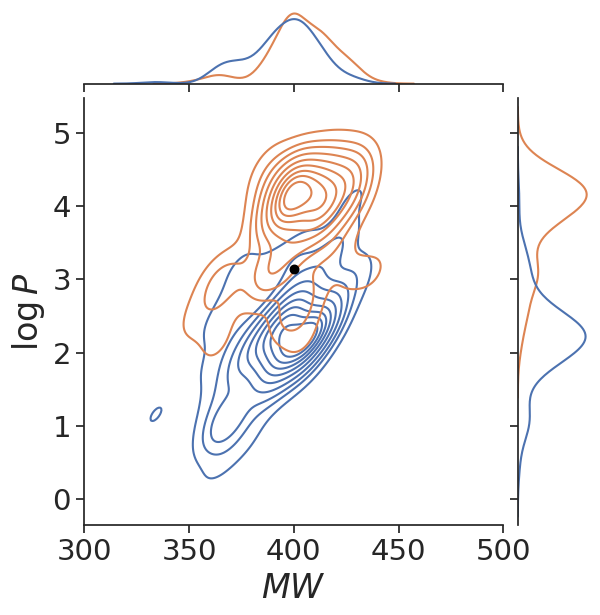

Test molecule: O=C(O)CNC(=O)c1ncc(C2CCN(C(=O)c3ccc(Cl)cc3)CC2)cc1O


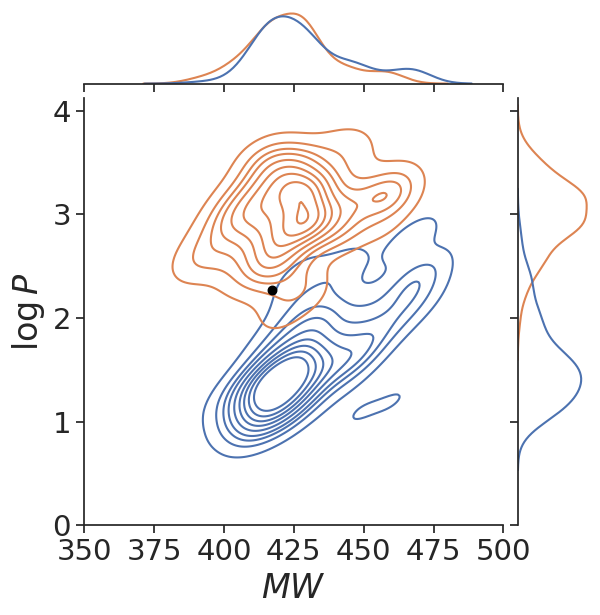

Test molecule: Cc1ccc(NC(=O)N2CCC(C(=O)NCCC3=CCCCC3)CC2)cc1


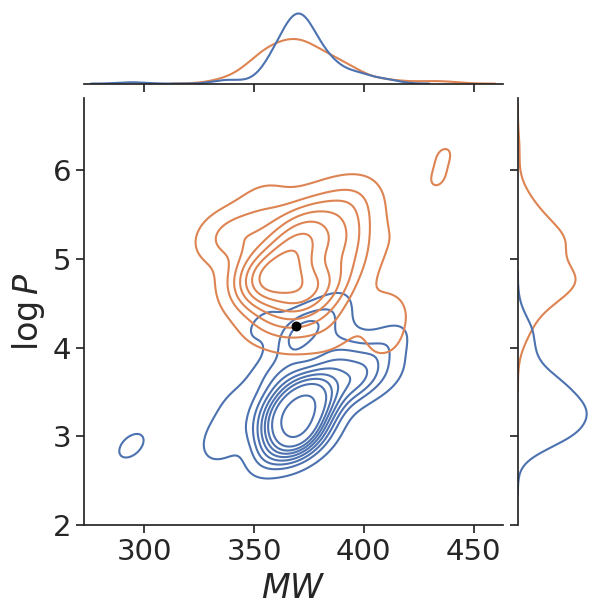

Leaving fragment difference:
0th: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1CC1CCCCCC1 -> leaving fragment count difference: 72
1th: O=C(O)CNC(=O)c1ncc(C2CCN(C(=O)c3ccc(Cl)cc3)CC2)cc1O -> leaving fragment count difference: 44
2th: Cc1ccc(NC(=O)N2CCC(C(=O)NCCC3=CCCCC3)CC2)cc1 -> leaving fragment count difference: 50


In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks")

# selecting test molecules
test_smi1 = "CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1CC1CCCCCC1"         # logP: 3.146
test_smi2 = "O=C(O)CNC(=O)c1ncc(C2CCN(C(=O)c3ccc(Cl)cc3)CC2)cc1O"      # logP: 2.27
test_smi3 = "Cc1ccc(NC(=O)N2CCC(C(=O)NCCC3=CCCCC3)CC2)cc1"             # logP: 4.246
test_molecules = [test_smi1, test_smi2, test_smi3]

leaving_frag_statistics = defaultdict(dict)
leaving_frag_statistics_path = f"{exp_save_dir}/leaving_frag_statistics.json"
for image_idx, query_smi in enumerate(test_molecules):

    # Read result dataframe
    corresponding_data = result_df[result_df["INPUT-MOL-SMI"] == query_smi]
    target_props = corresponding_data["PROPERTY_CONDITION"].unique()
    case = corresponding_data["CASE"].iloc[0]
    input_mol_idx = int(corresponding_data["INPUT-MOL-IDX"].iloc[0] / 2)
    for idx, target_prop in enumerate(target_props):
        prop_value_pairs = target_prop.split(" / ")
        props = [
            prop_value_pair.split(" ")[0] for prop_value_pair in prop_value_pairs
        ]
        target_props[idx] = props

    unique_target_props = []
    for target_prop in target_props:
        if target_prop in unique_target_props:
            continue
        else:
            unique_target_props.append(target_prop)

    assert len(unique_target_props) == 1
    target_props = unique_target_props[0]

    # 0. Properties of original molecule
    corr_case = corresponding_data["CASE"].iloc[0]
    original_smi = corresponding_data["INPUT-MOL-SMI"].iloc[0]
    original_props = calculate_properties(
        original_smi, [prop.lower() for prop in target_props]
    )
    original_x, original_y = (
        original_props[target_props[0]],
        original_props[target_props[1]],
    )

    corr_data_cond_informs = corresponding_data["PROPERTY_CONDITION"].to_list()
    new_corr_data_cond_informs = []
    for cond in corr_data_cond_informs:
        for prop_key, prop_value in DELTA_PROPS.items():
            if prop_key in cond:
                header, tail = cond.split(prop_key)
                cond = prop_value.join([header, tail])
        new_corr_data_cond_informs.append(cond)
    corresponding_data["PROPERTY_CONDITION"] = deepcopy(
        new_corr_data_cond_informs
    )

    # 1. Leaving fragment selection ratio
    property_conditions = list(corresponding_data["PROPERTY_CONDITION"].unique())
    for prop_condition in property_conditions:
        leaving_frag_statistics[query_smi][prop_condition] = dict()
        corresponding_condition_data = corresponding_data[
            corresponding_data["PROPERTY_CONDITION"] == prop_condition
        ]
        selected_leaving_frags = corresponding_condition_data[
            "LEAVING-FRAG-SMI"
        ].to_numpy()
        leaving_frags, frequencies = np.unique(
            selected_leaving_frags, return_counts=True
        )
        for frag, freq in zip(leaving_frags, frequencies):
            frag, freq = str(frag), int(freq)
            leaving_frag_statistics[query_smi][prop_condition][frag] = freq

    # 2. Visualization - Kernel density estimation
    g = sns.jointplot(
        data=corresponding_data,
        x=target_props[0].upper(),
        y=target_props[1].upper(),
        hue="PROPERTY_CONDITION",
        kind="kde",
        legend=False,
    )
    # plt.scatter(original_x, original_y, color='black', marker='.', s=150, label='Original Molecule')
    plt.scatter(
        original_x,
        original_y,
        color="black",
        marker=".",
        s=150,
        zorder=10,
    )
    # g.ax_joint.legend_.set_title("")
    g.ax_joint.set_xlabel(r"$\it{MW}$", fontsize=24)
    g.ax_joint.set_ylabel(r"$\log{P}$", fontsize=24)

    # Handling xticks and yticks for better visualization
    if image_idx == 0:
        x_ticks = np.arange(300, 501, 50)
        y_ticks = np.arange(0, 6, 1)
    elif image_idx == 1:
        x_ticks = np.arange(350, 501, 25)
        y_ticks = np.arange(0, 5, 1)
    elif image_idx == 2:
        x_ticks = np.arange(300, 451, 50)
        y_ticks = np.arange(2, 7, 1)

    g.ax_joint.set_xticks(x_ticks)
    g.ax_joint.set_yticks(y_ticks)
    g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), fontsize=21)
    g.ax_joint.set_yticklabels(g.ax_joint.get_yticklabels(), fontsize=21)

    g.savefig(f"{exp_save_dir}/{corr_case}_{input_mol_idx}_kde_{query_smi}.png", facecolor='white')
    g.savefig(f"{exp_save_dir}/{corr_case}_{input_mol_idx}_kde_{query_smi}.pdf", format="pdf", dpi=300, facecolor='white')

    print(f"Test molecule: {test_molecules[image_idx]}")
    plt.show(g)

with open(leaving_frag_statistics_path, "w") as f:
    json.dump(leaving_frag_statistics, f, indent=4)
        
# print leaving frag difference 
print("Leaving fragment difference:")
leaving_frag_difference = metric_leaving_frag_difference(leaving_frag_statistics_path)


### Leaving fragment statistics for the three selected test molecules

#### Visualization for removal fragment statistics

In [31]:
import io
import cairosvg
from collections import defaultdict

import numpy as np
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.FragmentMatcher import FragmentMatcher

from brics.brics import BRICSModule


In [45]:
from IPython.display import display, display_svg

def draw_leaving_frags(smi, leaving_frag_statistics, color_information, save_dir, verbose=False) -> None:
    # Basic settings
    mol = Chem.MolFromSmiles(smi)
    color, max_intensity = (
        color_information["color"],
        color_information["max_intensity"],
    )

    # Calculate weights for each atom
    atom_to_weight = {idx: 0 for idx in range(mol.GetNumAtoms())}
    for leaving_frag, count in leaving_frag_statistics.items():
        # Handling leaving fragment SMARTS
        leaving_frag_mol = Chem.MolFromSmiles(leaving_frag)
        for atom in leaving_frag_mol.GetAtoms():
            if atom.GetSymbol() == "*":
                atom.SetIsotope(0)
        frag_smarts_with_dummy = Chem.MolToSmiles(leaving_frag_mol)

        frag_smarts_copy = frag_smarts_with_dummy
        while "*" in frag_smarts_copy:
            leaving_frag_mol = Chem.MolFromSmiles(frag_smarts_copy)
            for atom in leaving_frag_mol.GetAtoms():
                if atom.GetSymbol() == "*":
                    dummy_atom_idx = atom.GetIdx()

            leaving_frag_rwmol = Chem.RWMol(leaving_frag_mol)
            BRICSModule.remove_dummy_atom(leaving_frag_rwmol, dummy_atom_idx)
            leaving_frag_mol = leaving_frag_rwmol.GetMol()
            frag_smarts_copy = Chem.MolToSmiles(leaving_frag_mol)

        frag_smarts_without_dummy = frag_smarts_copy

        matcher_with_dummy, matcher_without_dummy = FragmentMatcher(), FragmentMatcher()
        matcher_with_dummy.Init(frag_smarts_with_dummy)
        matcher_without_dummy.Init(frag_smarts_without_dummy)
        num_dummy = frag_smarts_with_dummy.count("*")

        matches_with_dummy = matcher_with_dummy.GetMatches(mol)
        matches_without_dummy = matcher_without_dummy.GetMatches(mol)

        if len(matches_with_dummy) == 0:
            raise ValueError("No matches found for matches_with_dummy.")

        elif len(matches_with_dummy) == 1:
            if len(matches_without_dummy) == 0:
                raise ValueError("No matches found for matches_without_dummy.")
            elif len(matches_without_dummy) == 1:
                match_with_dummy = matches_with_dummy[0]
                match_without_dummy = matches_without_dummy[0]
                match = tuple(
                    filter(lambda x: x in match_with_dummy, match_without_dummy)
                )
            elif len(matches_without_dummy) >= 2:
                if verbose:
                    print("\nManual handling required: len(matches_without_dummy) >= 2.")
                    print(f"smi: {smi}")
                    print(f"frag_smarts_with_dummy: {frag_smarts_with_dummy}")
                    print(f"frag_smarts_without_dummy: {frag_smarts_without_dummy}")
                    print(f"matches_with_dummy: {matches_with_dummy}")
                    print(f"matches_without_dummy: {matches_without_dummy}")

                if smi == test_smi1:
                    if leaving_frag == "[3*]O[3*]":
                        match = (11,)

        elif len(matches_with_dummy) >= 2:
            if verbose:
                print("\nManual handling required: len(matches_with_dummy) >= 2.")
                print(f"smi: {smi}")
                print(f"frag_smarts_with_dummy: {leaving_frag}")
                print(f"frag_smarts_without_dummy: {frag_smarts_without_dummy}")
                print(f"matches_with_dummy: {matches_with_dummy}")
                print(f"matches_without_dummy: {matches_without_dummy}")
            
            if smi == test_smi1:
                if leaving_frag == "[8*]CC":
                    match = (0,1,)
                elif leaving_frag == "[8*]C[8*]":
                    match = (12,)
            
            elif smi == test_smi2:
                if leaving_frag == "[5*]N[5*]":
                    match = (4,)
                elif leaving_frag == "[1*]C([6*])=O":
                    match = (5,6)
                elif leaving_frag == "[5*]NC([6*])=O":
                    match = (4,5,6)
            
            elif smi == test_smi3:
                if leaving_frag == "[5*]NC([6*])=O":
                    match = (14,12,13,)

                elif leaving_frag == "[1*]C(=O)N[5*]":
                    match = (5,6,7,)

                elif leaving_frag == "[5*]N[5*]":
                    match = (5,)

                elif leaving_frag == "[5*]N[4*]":
                    match = (14,)

        assert match in matches_without_dummy, \
            f"match is not matched,\nsmi: {smi}\nleaving_frag:{leaving_frag}\nmatch: {match}\nmatches_without_dummy:{matches_without_dummy}"

        for idx in match:
            atom_to_weight[idx] += int(count)

    # NOTE: the atom color weight is normalized by the maximum weight.
    # max_weight = 100
    max_weight = max(atom_to_weight.values())
    atom_to_weight = {k: v / max_weight for k, v in atom_to_weight.items()}

    atom_highlights = defaultdict(list)
    atom_rads = {}
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_color = deepcopy(color)
        atom_color = list(1.0 - (np.array(atom_color)* (-1) + 1.0) * max_intensity * atom_to_weight[atom_idx])
        atom_color.append(1.0)

        atom_highlights[atom_idx].append(tuple(atom_color))
        atom_rads[atom_idx] = 0.38

    bond_highlights = defaultdict(list)
    bond_rads = {}
    for bond in mol.GetBonds():
        atom_idx1 = bond.GetBeginAtomIdx()
        atom_idx2 = bond.GetEndAtomIdx()

        bond_idx = mol.GetBondBetweenAtoms(atom_idx1, atom_idx2).GetIdx()
        bond_color = color.copy()
        bond_weight = min(atom_to_weight[atom_idx1], atom_to_weight[atom_idx2])

        bond_color = list(1.0 - (np.array(bond_color)* (-1) + 1.0) * max_intensity * bond_weight)
        bond_color.append(1.0)

        bond_highlights[bond_idx].append(tuple(bond_color))
        bond_rads[bond_idx] = 1

    bond_highlights = dict(bond_highlights)
    
    # Using SVG for visualization
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(-1, -1)
    draw_options = d2d.drawOptions()
    draw_options.useBWAtomPalette()
    d2d.DrawMoleculeWithHighlights(
        mol=mol,
        legend="",
        highlight_atom_map=dict(atom_highlights),
        highlight_bond_map=dict(bond_highlights),
        highlight_radii=atom_rads,
        highlight_linewidth_multipliers={}
        # highlight_linewidth_multipliers=bond_rads,
    )
    d2d.FinishDrawing()
    cairosvg.svg2pdf(
        bytestring=d2d.GetDrawingText().encode(),
        write_to=f"{save_dir}/removal_{smi_idx+1}th_mol_{cond_idx+1}th_condition.pdf",
        dpi=300
    )
    display_svg(d2d.GetDrawingText(), raw=True)

0 CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1CC1CCCCCC1


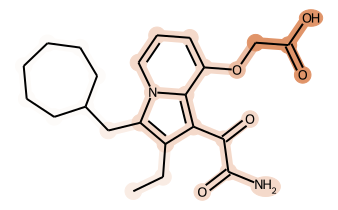

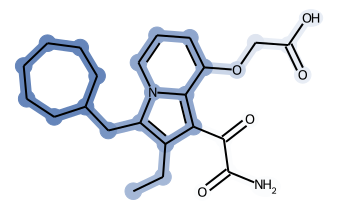

1 O=C(O)CNC(=O)c1ncc(C2CCN(C(=O)c3ccc(Cl)cc3)CC2)cc1O


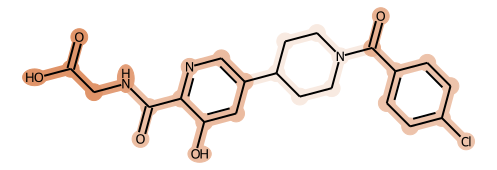

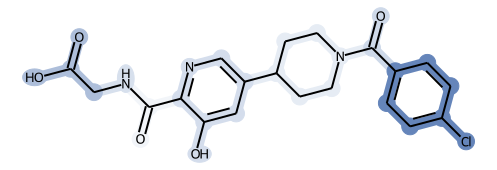

2 Cc1ccc(NC(=O)N2CCC(C(=O)NCCC3=CCCCC3)CC2)cc1


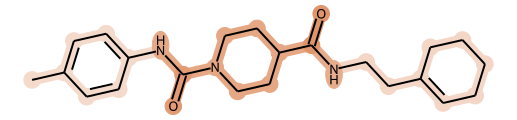

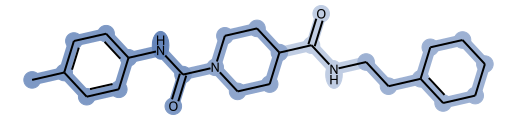

In [46]:
# Read leaving frag statistics
with open(f"{exp_save_dir}/leaving_frag_statistics.json", "r") as f:
    leaving_frag_statistics = json.load(f)

# Color setting - RGB
orange = [225, 149, 106]
blue = [85, 121, 180]

orange_max_intensity = 1.0
blue_max_intensity = 0.9

orange = (np.array(orange) * np.array([1 / 256, 1 / 256, 1 / 256])).tolist()
blue = (np.array(blue) * np.array([1 / 256, 1 / 256, 1 / 256])).tolist()

color_list = [orange, blue]
max_intensity_list = [orange_max_intensity, blue_max_intensity]

# Property control conditions
conditions = [
    "$\\Delta Mw$ 0.00 / $\\Delta logP$ 1.00",
    "$\\Delta Mw$ 0.00 / $\\Delta logP$ -1.00",
]

# Draw Figures
for smi_idx, smi in enumerate(test_molecules):
    print(smi_idx, smi)
    for cond_idx, condition in enumerate(conditions):
        color_inform = {
            "color": color_list[cond_idx],
            "max_intensity": max_intensity_list[cond_idx],
        }
        statistics = leaving_frag_statistics[smi][condition]
        draw_leaving_frags(smi, statistics, color_inform, exp_save_dir)